# MNIST handwritten digits classification with MLPs

Author: Bethany Lusch, adapting codes from Prasanna Balprakash, Corey Adams, and Kyle Felker

In this notebook, we'll continue the MNIST problem but using the Keras API (as included in the TensorFlow library)

First, the needed imports.

In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

## MNIST data set

Again we'll load the MNIST handwritten digits data set.  If you haven't downloaded it already, it could take a while.


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

print()
print('MNIST data loaded: train:',len(x_train),'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)


MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 28, 28)
y_train: (60000,)


This time we won't flatten the images upfront. 

The training data (`X_train`) is a 3rd-order tensor of size (60000, 28, 28), i.e. it consists of 60000 images of size 28x28 pixels. 

`y_train` is a 60000-dimensional vector containing the correct classes ("0", "1", ..., "9") for each training sample.

## Linear model

### Initialization

Let's begin with a simple linear model, but with the Keras library. First we use a `Flatten` layer to convert image data into vectors. 

Then we add a `Dense` layer that has 28*28=784 input nodes (one for each pixel in the input image) and 10 output nodes. The `Dense` layer connects each input to each output with some weight parameter. 

In [3]:
class LinearClassifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.layer_1 = tf.keras.layers.Dense(10, activation='softmax')


    def call(self, inputs):

        x = tf.keras.layers.Flatten()(inputs)
        x = self.layer_1(x)

        return x

We select *sparse categorical crossentropy* as the loss function, select [*stochastic gradient descent*](https://keras.io/optimizers/#sgd) as the optimizer, add *accuracy* to the list of metrics to be evaluated, and `compile()` the model. Note there are [several different options](https://keras.io/optimizers/) for the optimizer in Keras that we could use instead of *sgd*.

In [4]:
linear_model = LinearClassifier()

linear_model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

### Learning

Now we are ready to train our first model. An epoch means one pass through the whole training data.

Here is a concise way to train the network. The fit function handles looping over the batches. We'll see a more verbose approach in the next notebook that allows more performance tuning.

You can run the code below multiple times and it will continue the training process from where it left off. If you want to start from scratch, re-initialize the model using the code a few cells ago.

In [5]:
%%time
# This took about a third of a second per epoch on my laptop
batch_size = 512
epochs = 30
history = linear_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2)

Train on 60000 samples
Epoch 1/30
60000/60000 - 1s - loss: 1.8393 - accuracy: 0.4781
Epoch 2/30
60000/60000 - 0s - loss: 1.2810 - accuracy: 0.7407
Epoch 3/30
60000/60000 - 0s - loss: 1.0223 - accuracy: 0.7953
Epoch 4/30
60000/60000 - 0s - loss: 0.8796 - accuracy: 0.8170
Epoch 5/30
60000/60000 - 0s - loss: 0.7893 - accuracy: 0.8300
Epoch 6/30
60000/60000 - 0s - loss: 0.7267 - accuracy: 0.8389
Epoch 7/30
60000/60000 - 0s - loss: 0.6805 - accuracy: 0.8457
Epoch 8/30
60000/60000 - 0s - loss: 0.6448 - accuracy: 0.8506
Epoch 9/30
60000/60000 - 0s - loss: 0.6162 - accuracy: 0.8548
Epoch 10/30
60000/60000 - 0s - loss: 0.5927 - accuracy: 0.8579
Epoch 11/30
60000/60000 - 0s - loss: 0.5730 - accuracy: 0.8608
Epoch 12/30
60000/60000 - 0s - loss: 0.5562 - accuracy: 0.8637
Epoch 13/30
60000/60000 - 0s - loss: 0.5416 - accuracy: 0.8660
Epoch 14/30
60000/60000 - 0s - loss: 0.5289 - accuracy: 0.8681
Epoch 15/30
60000/60000 - 0s - loss: 0.5176 - accuracy: 0.8701
Epoch 16/30
60000/60000 - 0s - loss: 0.50

In [6]:
print(linear_model.summary())

Model: "linear_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None


The summary shows that there are 7850 parameters in our model, as the weight matrix is of size 785x10 (not 784, as there's an additional bias term).

Let's now see how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the training data (100*accuracy is the percentage labeled correctly), so it should increase over time

Note that for either measure, we cannot fully trust the progress, as the model may have overfitted and just memorized the training data.

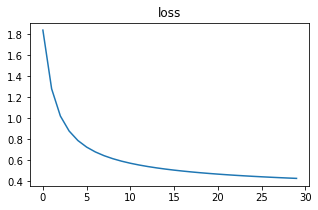

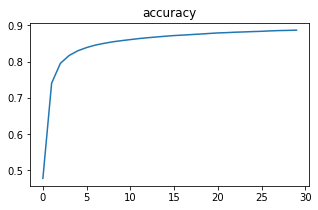

In [7]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

For a better measure of the quality of the model, let's see the model accuracy for the test data. 

In [8]:
linscores = linear_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (linear_model.metrics_names[1], linscores[1]*100))

10000/1 - 0s - loss: 0.3516 - accuracy: 0.8942
accuracy: 89.42%


We can now take a closer look on the results.

Let's define a helper function to show the failure cases of our classifier. 

In [9]:
def show_failures(predictions, trueclass=None, predictedclass=None, maxtoshow=10):
    rounded = numpy.argmax(predictions, axis=1)
    errors = rounded!=y_test
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parenthesis.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(x_test.shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            if trueclass is not None and y_test[i] != trueclass:
                continue
            if predictedclass is not None and rounded[i] != predictedclass:
                continue
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(x_test[i,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], y_test[i]))
            ii = ii + 1

Here are the first 10 test digits the linear model classified to a wrong class:

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


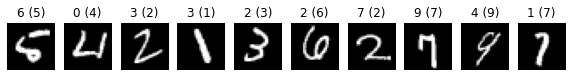

In [10]:
linpredictions = linear_model.predict(x_test)

show_failures(linpredictions)

## Multi-layer perceptron (MLP) network

### Initialization

Let's now create a more complex MLP model that has multiple layers, non-linear activation functions, and dropout layers. 
- A `Dense()` layer is a basic layer: $xA + b$ with an optional nonlinearity applied ("activation function"). The layers are "densely" connected (also called "fully connected") with a dense matrix.

- `Dropout()` randomly sets a fraction of inputs to zero during training, which is one approach to regularization and can sometimes help to prevent overfitting. 

There are two options below, a simple and a bit more complex model.  Select either one.

The output of the last layer needs to be a softmaxed 10-dimensional vector to match the groundtruth (`y_train`). 

In [11]:
class NonlinearClassifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.layer_1 = tf.keras.layers.Dense(20, activation='relu')
        
        # A bit more complex model: (need to uncomment in call fn as well)
        #self.layer_2 = tf.keras.layers.Dense(50, activation='relu')
        #self.drop_3 = tf.keras.layers.Dropout(0.2)
        #self.layer_4 = tf.keras.layers.Dense(50, activation='relu')
        #self.drop_5 = tf.keras.layers.Dropout(0.2)
        
        # The last layer needs to be like this:
        self.layer_out = tf.keras.layers.Dense(10, activation='softmax')


    def call(self, inputs):

        x = tf.keras.layers.Flatten()(inputs)
        x = self.layer_1(x)
        
        # The more complex version:
        #x = self.layer_2(x)
        #x = self.drop_3(x)
        #x = self.layer_4(x)
        #x = self.drop_5(x)
        
        x = self.layer_out(x)

        return x

Finally, we again `compile()` the model, this time using [*RMSProp*](https://keras.io/optimizers/#rmsprop) as the optimizer.

In [12]:
nonlinear_model = NonlinearClassifier()

nonlinear_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])

### Learning

In [13]:
%%time
# This took around half a second per epoch on my laptop for the simpler version, 
# and around 1 second per epoch for the more complex one.
batch_size = 512
epochs = 30
history = nonlinear_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2)

Train on 60000 samples
Epoch 1/30
60000/60000 - 1s - loss: 0.8545 - accuracy: 0.7829
Epoch 2/30
60000/60000 - 0s - loss: 0.3633 - accuracy: 0.9024
Epoch 3/30
60000/60000 - 0s - loss: 0.2964 - accuracy: 0.9175
Epoch 4/30
60000/60000 - 0s - loss: 0.2644 - accuracy: 0.9257
Epoch 5/30
60000/60000 - 0s - loss: 0.2422 - accuracy: 0.9327
Epoch 6/30
60000/60000 - 0s - loss: 0.2252 - accuracy: 0.9366
Epoch 7/30
60000/60000 - 0s - loss: 0.2119 - accuracy: 0.9403
Epoch 8/30
60000/60000 - 0s - loss: 0.2011 - accuracy: 0.9428
Epoch 9/30
60000/60000 - 0s - loss: 0.1922 - accuracy: 0.9461
Epoch 10/30
60000/60000 - 0s - loss: 0.1839 - accuracy: 0.9477
Epoch 11/30
60000/60000 - 0s - loss: 0.1775 - accuracy: 0.9500
Epoch 12/30
60000/60000 - 0s - loss: 0.1709 - accuracy: 0.9516
Epoch 13/30
60000/60000 - 0s - loss: 0.1654 - accuracy: 0.9535
Epoch 14/30
60000/60000 - 0s - loss: 0.1604 - accuracy: 0.9546
Epoch 15/30
60000/60000 - 0s - loss: 0.1556 - accuracy: 0.9563
Epoch 16/30
60000/60000 - 0s - loss: 0.15

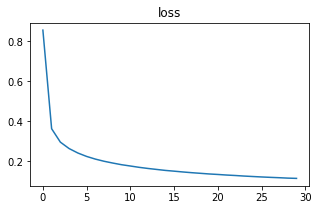

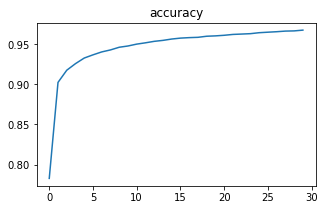

In [14]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

Accuracy for test data.  The model should be better than the linear model. 

In [15]:
%%time
scores = nonlinear_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (nonlinear_model.metrics_names[1], scores[1]*100))

10000/1 - 1s - loss: 0.0807 - accuracy: 0.9556
accuracy: 95.56%
CPU times: user 1.19 s, sys: 3.26 s, total: 4.46 s
Wall time: 613 ms


We can again take a closer look on the results, using the `show_failures()` function defined earlier.

Here are the first 10 test digits the MLP classified to a wrong class:

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


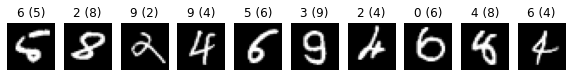

In [16]:
predictions = nonlinear_model.predict(x_test)

show_failures(predictions)

We can use `show_failures()` to inspect failures in more detail. For example, here are failures in which the true class was "6":

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


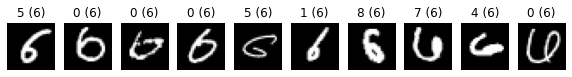

In [17]:
show_failures(predictions, trueclass=6)

We can also compute the confusion matrix to see which digits get mixed the most, and look at classification accuracies separately for each class:

In [18]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

[[ 962    0    4    1    1    1    9    1    1    0]
 [   0 1119    4    0    0    2    4    1    5    0]
 [   8    1  977    8    5    1    7   10   14    1]
 [   1    5    9  964    3    8    0   10    5    5]
 [   1    1    8    2  923    0    8    5    5   29]
 [   4    2    1   21    3  829    9    3   15    5]
 [   8    3    0    0    4    6  932    1    4    0]
 [   1    2   15   14    0    0    0  981    4   11]
 [   2    2    6   17    5    6    8    7  919    2]
 [   2    6    3   15   15    4    1    9    4  950]]

Classification accuracy for each class:

0: 0.9816
1: 0.9859
2: 0.9467
3: 0.9545
4: 0.9399
5: 0.9294
6: 0.9729
7: 0.9543
8: 0.9435
9: 0.9415


In the next notebook, we'll introduce convolutional layers, which are commonly used for images.